## Raspagem de dados do site TOTALCORNER e montando o DataFrame

In [7]:
from bs4 import BeautifulSoup
import pandas as pd
import time
import matplotlib.pyplot as plt
import cloudscraper

#Raspagem de dados to site TOTALCORNER
def get_corner_stats(team_id:str,is_home:bool='all'):
    scraper = cloudscraper.create_scraper()    
    html = scraper.get(f'https://www.totalcorner.com/team/view/{team_id}').content

    soup = BeautifulSoup(html, 'html.parser')
    if not soup.find("meta", {"name":"description"}):
        print('CAPTCHA')
        return (None, None)
    team_name = soup.find("meta", {"name":"description"})["content"]
    team_name = team_name.split(",")[0].replace('Team: ','')
    first_half_corners_for = []
    second_half_corners_for = []
    match_corners_for = []
    first_half_corners_against = []
    second_half_corners_against = []
    match_corners_against = []
    total_match_corners = []
    total_first_half_corners = []
    total_second_half_corners =[]
    home_or_away = []
    corners_balance =[]
    against = []



    table_rows = soup.findAll("tr")
    for rows in table_rows:
        #Ignorando jogos que ainda não aconteceram
        if rows.find("span", class_="span_half_corner hide"):
            continue
        match = rows.find("td", class_="match_home")
        #Pegando nome do time que joga em casa
        if match != None:
            home_team = match.find('a').text
        #Ignorando possiveis linhas que não são referente a partidas
        else:
            continue
        match = rows.find("td", class_="match_away")
        #Pegando nome do time que joga fora de casa
        if match != None:
            away_team = match.find('a').text
        #Pegando dados sobre escanteios
        half_corners = rows.find("span", class_="span_half_corner").text
        match_corners = rows.find("span", class_="span_match_corner").text
        home_half_corners = half_corners.replace('(','').replace(')','').split('-')[0]
        away_half_corners = half_corners.replace('(','').replace(')','').split('-')[1]
        home_match_corners = match_corners.split(' ')[0]
        away_match_corners = match_corners.split(' ')[-1]
        home_second_half_corners = int(home_match_corners) - int(home_half_corners)
        away_second_half_corners = int(away_match_corners) - int(away_half_corners)
        #Organizando dados para o dataframe
        if home_team == team_name:
            against.append(away_team)            
            balance = int(home_match_corners) - int(away_match_corners)
            first_half_corners_for.append(int(home_half_corners))
            second_half_corners_for.append(int(home_second_half_corners))
            match_corners_for.append(int(home_match_corners))
            first_half_corners_against.append(int(away_half_corners))
            second_half_corners_against.append(int(away_second_half_corners))
            match_corners_against.append(int(away_match_corners))
            total_match_corners.append(int(home_match_corners) + int(away_match_corners))
            total_first_half_corners.append(int(home_half_corners) + int(away_half_corners))
            total_second_half_corners.append(int(home_second_half_corners) + int(away_second_half_corners))
            home_or_away.append('Home')
            corners_balance.append(balance)

        else:
            against.append(home_team)  
            balance = int(away_match_corners) - int(home_match_corners)
            first_half_corners_for.append(int(away_half_corners))
            second_half_corners_for.append(int(away_second_half_corners))
            match_corners_for.append(int(away_match_corners))
            first_half_corners_against.append(int(home_half_corners))
            second_half_corners_against.append(int(home_second_half_corners))
            match_corners_against.append(int(home_match_corners))
            total_match_corners.append(int(home_match_corners) + int(away_match_corners))
            total_first_half_corners.append(int(home_half_corners) + int(away_half_corners))
            total_second_half_corners.append(int(home_second_half_corners) + int(away_second_half_corners))
            home_or_away.append('Away')
            corners_balance.append(balance)
    #Criando DataFrame
    df = pd.DataFrame(list(zip(
            first_half_corners_for,
            second_half_corners_for,
            match_corners_for,
            first_half_corners_against,
            second_half_corners_against,
            match_corners_against,
            total_match_corners,
            total_first_half_corners,
            total_second_half_corners,
            home_or_away,
            corners_balance,
            against
        )),
        columns=[
            'first_half_corners_for',
            'second_half_corners_for',
            'match_corners_for',
            'first_half_corners_against',
            'second_half_corners_against',
            'match_corners_against',
            'total_match_corners',
            'total_first_half_corners',
            'total_second_half_corners',
            'home_or_away',
            'corners_balance',
            'against'

        ])
    if is_home == 'all':
        return (team_name, df)
    if is_home:
        return (team_name, df[(df.home_or_away == "Home")])
    else:
        return (team_name, df[(df.home_or_away == "Away")])


### Criando relátorio com fairlines de escanteios para as principais partidas de hoje

In [8]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import datetime

games_percentage = 0.70
lower_part = (1-games_percentage)/2
higher_part = games_percentage + lower_part

def get_fairlines(corner_lines_range,home_corner_series,away_corner_series,over_or_under,ft_or_1h):
    fairlines = {}
    if over_or_under.lower() == 'over':
        for corner in corner_lines_range:
                #Percentual de partidas com MAIS de X escanteios
                home = (home_corner_series > corner).mean()
                away = (away_corner_series > corner).mean()
                if home == 0 or away == 0:
                    home = 9999
                else:
                    home = round(1/home,2)
                    away = round(1/away,2)
                fairlines[f'{ft_or_1h}_over_{corner}.5'] = max(home,away)
    else:
        for corner in corner_lines_range:
                #Percentual de partidas com MENOS de X escanteios
                home = (home_corner_series < corner).mean()
                away = (away_corner_series < corner).mean()
                if home == 0 or away == 0:
                    home = 9999
                else:
                    home = round(1/home,2)
                    away = round(1/away,2)
                fairlines[f'{ft_or_1h}_under_{corner - 1 }.5'] = max(home,away)
    return fairlines



def generate_report():
    desired_leagues = ["France Ligue 1",'Portugal Primeira Liga','Netherlands Eredivisie','	Spain Primera Liga','Spain Segunda','Italy Serie B',
                       'England Championship','England Premier League','Germany Bundesliga I','Italy Serie A','Colombia Primera A','Uruguay Apertura',
                        'Chile Primera Division','Argentina Liga Profesional','USA MLS','Paraguay Division Profesional',
                       'Venezuela Primera Division','Mexico Liga MX','Japan J-League','Germany Bundesliga II','UEFA Champions League',
                       'Copa do Brasil','Copa Libertadores','Copa Sudamericana','UEFA Europa League']
    result = []
    html = requests.get('https://www.totalcorner.com/match/today').content
    soup = BeautifulSoup(html, 'html.parser')
    table_rows = soup.findAll("tr")
    #Lendo as linhas da tabela
    for rows in table_rows:
        game = {}
        minutes = rows.find('span', class_="match_status_minutes")
        #ignorando linhas que não tem a coluna de tempo da partida
        if not minutes:
            continue
        #ignorando partidas que já começaram
        if minutes.text == "":
            links = rows.findAll('a', href=True)
            league = links[0].text
            #Filtrando ligas
            if league not in desired_leagues:
                continue
            #Pegando ID dos times
            home_team_id = links[1]['href'].split('/')[-1]
            away_team_id = links[2]['href'].split('/')[-1]
            #Pegando os dados de escanteios dos times.
            home_team_name, df_home = get_corner_stats(home_team_id,True)
            away_team_name, df_away = get_corner_stats(away_team_id,False)
            #Encerra o loop caso o site peça CAPTCHA
            if not (home_team_name and away_team_name):
                break
            else:
                game['Name'] = f'{home_team_name} X {away_team_name}'
                #Percentual de partidas com saldo de escanteios positivos e negativos
                home_balance = round((df_home.corners_balance > 0).mean()*100)
                negative_home_balance = round((df_home.corners_balance < 0).mean()*100)
                away_balance = round((df_away.corners_balance > 0).mean()*100)
                negative_away_balance = round((df_away.corners_balance < 0).mean()*100)
                #Definindo linhas de over e under escanteios para analise
                first_half_over_range = range(1,6)
                first_half_under_range = range(7,4,-1)
                full_time_over_range = range(6,13)
                full_time_under_range = range(12,8,-1)

                print(f'{home_team_name} X {away_team_name}')
                game.update(get_fairlines(first_half_over_range,df_home.total_first_half_corners,df_away.total_first_half_corners,'over','1H'))
                game.update(get_fairlines(first_half_under_range,df_home.total_first_half_corners,df_away.total_first_half_corners,'under','1H'))
                game.update(get_fairlines(full_time_over_range,df_home.total_match_corners,df_away.total_match_corners,'over','FT'))
                game.update(get_fairlines(full_time_under_range,df_home.total_match_corners,df_away.total_match_corners,'under','FT'))
                result.append(game)

                balance_dif = home_balance - away_balance 
                if abs(balance_dif) >= 40:
                    if(home_balance > away_balance):
                        fair = 1/((home_balance + negative_away_balance)/200)
                        game.update({'most_corners':home_team_name,'most_corners_fairline':fair})
                    else:
                        fair = 1/((negative_home_balance + away_balance)/200)
                        game.update({'most_corners':home_team_name,'most_corners_fairline':fair})
                else:
                    game.update({'most_corners':'-','most_corners_fairline':'-'})
    result_df = pd.DataFrame.from_records(result)
    result_df.to_excel(f'fairlines{datetime.date.today()}.xlsx', index=False,sheet_name='Fairlines')      



generate_report()

San Lorenzo X Fortaleza FC
Santos X Audax Italiano
Penarol X Millonarios
Racing Club X SD Aucas
Botafogo RJ X Cesar Vallejo
Atletico Nacional X FBC Melgar
Palmeiras X Cerro Porteno
Universitario de Deportes X Goias
Emelec X Huracan
Deportes Tolima X CA Tigre
Libertad Asuncion X Alianza Lima
Tigres UANL X Puebla


### Pegando odds da Betano

In [24]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By


def get_odds(search_term):
    try:
        print('Getting odds for', search_term)
        url = "https://br.betano.com/" 
        options = webdriver.ChromeOptions()
        options.add_argument('--headless')
        options.add_argument('--window-size=1920x1080')
        driver = webdriver.Chrome(options=options)
        driver.get(url) 
        
        # Garantindo que a pagina foi carregada
        time.sleep(2)
        #Fechando popup inicial
        close_modal = driver.find_element(By.CLASS_NAME,'sb-modal__close__btn')
        close_modal.click()
        #clicando no icone de busca
        search = driver.find_element(By.CLASS_NAME,'sb-header__header__actions__search-icon')
        search.click()
        time.sleep(1)
        #Digitando confronto no input de busca
        driver.find_element(By.CLASS_NAME,'uk-input').send_keys(search_term)
        time.sleep(3)
        if len(driver.find_elements(By.CLASS_NAME,'search-modal__empty-state')) != 0:
            driver.find_element(By.CLASS_NAME,'uk-input').send_keys(Keys.CONTROL + "a")
            driver.find_element(By.CLASS_NAME,'uk-input').send_keys(Keys.DELETE)
            driver.find_element(By.CLASS_NAME,'uk-input').send_keys(search_term.split('X')[0])
            time.sleep(3)
        #Caso não seja encontrado retorna um objeto com o nome do confronto
        if len(driver.find_elements(By.CLASS_NAME,'search-modal__empty-state')) != 0:
            print('Jogo Não encontrado')
            return {'Name':search_term}
        #Caso encontrado clica no primeiro resultado
        else:
            if len(driver.find_elements(By.CLASS_NAME,'search-result')) == 0:
                time.sleep(4)
            driver.find_element(By.CLASS_NAME,'search-result').click()
            time.sleep(5)
            #Procura categoria escanteio e clica nela
            categories = driver.find_elements(By.CLASS_NAME,'GTM-tab-name')
            for category in categories:
                if 'escanteios' in category.get_attribute("innerHTML").lower():
                    category.click()
                    time.sleep(2)
            #passa o html estatico para o beautiful soup
            html = driver.page_source
            soup = BeautifulSoup(html, "html.parser")
            #Pega todos os mercados de escanteios
            corner_markets = soup.find_all('div',class_='markets__market__header__title')
            market_titles = ['Name']
            market_odds = [search_term]
            #Filtra apenas os mercados de interesse (FT Mais/Menos e HT Mais/Menos)
            #Armazena as odds e o nome do mercado em uma lista cada.
            for market in corner_markets:
                if 'Escanteios' in market.text.split()[0] and 'Mais/Menos' in market.text.split()[1]:
                    parent_tag = market.parent.parent
                    titles = parent_tag.find_all('span',class_='selections__selection__title')
                    odds = parent_tag.find_all('span',class_='selections__selection__odd')
                    market_titles = market_titles + [title.text.replace('Mais de','FT_over_').replace('Menos de','FT_under_') for title in titles]
                    market_odds = market_odds + [odd.text.split()[0] for odd in odds]
                if 'Mais/Menos' in market.text.split()[0] and '1' in market.text.split()[1]:
                    parent_tag = market.parent.parent
                    titles = parent_tag.find_all('span',class_='selections__selection__title')
                    odds = parent_tag.find_all('span',class_='selections__selection__odd')
                    market_titles = market_titles + [title.text.replace('Mais de','1H_over_').replace('Menos de','1H_under_') for title in titles]
                    market_odds = market_odds + [odd.text.split()[0] for odd in odds]
            print('Odds Found !')        
            return dict(zip(market_titles,market_odds))
    except Exception as e:
        print('Error getting odds',str(e))
        return {'Name':search_term}
        

        


### Preenchendo planilha com ODDS betano

In [25]:
#Lê a planilha com as fairlines criadas
df_fairlines = pd.read_excel(f'fairlines{datetime.date.today()}.xlsx')
odds_result = []
#Para cada jogo busca as odds na betano
for game in list(df_fairlines.Name):
    odds_result.append(get_odds(game))
#Cria um dataframe com as odds
odds_df = pd.DataFrame.from_records(odds_result)
display(odds_df)



Getting odds for San Lorenzo X Fortaleza FC
Odds Found !
Getting odds for Santos X Audax Italiano
Odds Found !
Getting odds for Penarol X Millonarios
Odds Found !
Getting odds for Racing Club X SD Aucas
Odds Found !
Getting odds for Botafogo RJ X Cesar Vallejo
Odds Found !
Getting odds for Atletico Nacional X FBC Melgar
Odds Found !
Getting odds for Palmeiras X Cerro Porteno
Odds Found !
Getting odds for Universitario de Deportes X Goias
Odds Found !
Getting odds for Emelec X Huracan
Odds Found !
Getting odds for Deportes Tolima X CA Tigre
Odds Found !
Getting odds for Libertad Asuncion X Alianza Lima
Odds Found !
Getting odds for Tigres UANL X Puebla
Odds Found !


,Name,FT_over_9.5,FT_under_9.5,1H_over_4.5,1H_under_4.5,FT_over_4.5,FT_under_4.5,FT_over_5.5,FT_under_5.5,FT_over_6.5,...,1H_over_9.5,1H_under_9.5,1H_over_3.5,1H_under_3.5,FT_over_3.5,FT_under_3.5,FT_over_17.5,FT_under_17.5,FT_over_18.5,FT_under_18.5
0,San Lorenzo X Fortaleza FC,1.98,1.78,1.98,1.78,1.03,10.00,1.08,6.90,1.17,...,12.50,1.01,1.45,2.65,NaN,NaN,NaN,NaN,NaN,NaN
1,Santos X Audax Italiano,2.07,1.70,2.05,1.72,1.04,9.50,1.09,6.50,1.19,...,12.50,1.01,1.47,2.55,1.01,12.50,NaN,NaN,NaN,NaN
2,Penarol X Millonarios,2.07,1.70,2.05,1.72,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.47,2.55,NaN,NaN,NaN,NaN,NaN,NaN
3,Racing Club X SD Aucas,1.82,1.93,1.85,1.88,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.39,2.85,NaN,NaN,NaN,NaN,NaN,NaN
4,Botafogo RJ X Cesar Vallejo,1.90,1.85,1.91,1.83,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.42,2.72,NaN,NaN,NaN,NaN,NaN,NaN
5,Atletico Nacional X FBC Melgar,1.82,1.91,1.87,1.88,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.40,2.82,NaN,NaN,NaN,NaN,NaN,NaN
6,Palmeiras X Cerro Porteno,1.45,2.62,1.57,2.30,NaN,NaN,1.03,10.25,1.07,...,10.00,1.03,1.26,3.65,NaN,NaN,10.75,1.02,12.50,1.01
7,Universitario de Deportes X Goias,1.95,1.78,1.95,1.78,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.44,2.65,NaN,NaN,NaN,NaN,NaN,NaN
8,Emelec X Huracan,2.02,1.75,2.00,1.75,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.47,2.57,NaN,NaN,NaN,NaN,NaN,NaN
9,Deportes Tolima X CA Tigre,1.91,1.83,1.91,1.82,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.42,2.72,NaN,NaN,NaN,NaN,NaN,NaN


### Limpando e organizando os dataframes de ODDS e Fairlines para compará-los e encontrar oportunidades

In [26]:
df_fairlines = pd.read_excel(f'fairlines{datetime.date.today()}.xlsx')
odds_df = pd.DataFrame.from_records(odds_result)
#Removendo colunas de odds que não tenham fairlines calculadas
for column in odds_df.columns:
    if column not in df_fairlines.columns:
        odds_df.drop(column,inplace=True, axis='columns')
#Removendo colunas com mercados especiais
df_fairlines.drop(['most_corners','most_corners_fairline'],axis='columns',inplace=True)
#Reordenando as colunas
cols = list(odds_df.columns)
cols.pop(0)
sorted_cols = sorted(cols)
sorted_cols.insert(0,'Name')
odds_df = odds_df[sorted_cols]
df_fairlines = df_fairlines[sorted_cols]
#Removendo linhas que não foram encontradas odds na betano
df_fairlines = df_fairlines[df_fairlines.Name.isin(odds_df.Name)]
df_fairlines.reset_index(inplace=True,drop=True)
#Criando novo dataframe com a diferença entre fairline e odds
diff = pd.DataFrame()
df_fairlines.iloc[:,1:] = df_fairlines.iloc[:,1:].astype(float)
odds_df.iloc[:,1:] = odds_df.iloc[:,1:].astype(float)
diff['Name']= df_fairlines.Name
diff = pd.concat([diff, df_fairlines.iloc[:,1:] - odds_df.iloc[:,1:]],axis=1)
display(diff)



,Name,1H_over_1.5,1H_over_2.5,1H_over_3.5,1H_over_4.5,1H_over_5.5,1H_under_4.5,1H_under_5.5,1H_under_6.5,FT_over_10.5,FT_over_11.5,FT_over_12.5,FT_over_6.5,FT_over_7.5,FT_over_8.5,FT_over_9.5,FT_under_10.5,FT_under_11.5,FT_under_8.5,FT_under_9.5
0,San Lorenzo X Fortaleza FC,0.05,0.4,0.38,0.77,0.77,0.72,0.05,0.04,1.1,2.0,9994.2,1.03,0.87,1.18,1.69,0.2,0.39,1.03,1.55
1,Santos X Audax Italiano,0.05,0.14,0.03,-0.05,2.45,0.48,0.15,0.17,-0.55,-0.08,0.3,0.01,0.13,0.06,0.13,0.58,0.47,1.52,0.7
2,Penarol X Millonarios,NaN,0.08,0.86,1.45,1.62,0.06,0.1,-0.08,1.25,0.25,NaN,NaN,0.38,0.35,1.43,-0.02,0.16,0.52,-0.1
3,Racing Club X SD Aucas,NaN,0.47,0.47,0.75,1.66,0.72,0.73,0.23,0.93,9.9,NaN,NaN,0.17,0.67,0.35,0.29,0.1,1.83,0.67
4,Botafogo RJ X Cesar Vallejo,NaN,0.11,0.33,0.42,-0.47,0.17,0.6,0.24,1.05,1.37,NaN,NaN,0.26,0.22,0.9,0.98,1.19,0.93,1.48
5,Atletico Nacional X FBC Melgar,NaN,0.12,0.93,0.93,0.3,0.12,0.14,0.12,1.15,1.57,NaN,NaN,0.73,2.0,1.68,0.16,-0.01,0.5,0.09
6,Palmeiras X Cerro Porteno,0.07,0.11,0.74,0.83,9.85,0.9,0.64,0.66,1.25,1.85,3.18,0.02,0.06,0.24,0.95,0.65,0.64,0.4,0.05
7,Universitario de Deportes X Goias,NaN,0.03,0.96,1.05,3.1,1.47,1.87,0.68,3.43,9995.55,NaN,NaN,0.38,0.83,4.05,1.78,0.89,4.2,2.55
8,Emelec X Huracan,NaN,0.26,0.36,0.75,0.67,-0.13,0.08,0.21,-0.45,-0.35,NaN,NaN,0.09,0.26,0.18,0.42,0.31,-0.05,0.11
9,Deportes Tolima X CA Tigre,NaN,0.33,0.08,0.59,2.18,0.18,0.31,0.14,7.53,8.7,NaN,NaN,0.7,0.97,1.42,0.21,-0.19,1.6,1.17


In [27]:
def get_odds(row):
    return odds_df.loc[odds_df["Name"] == row['Jogo']][row['Market']].values[0]
#Criando dataFrame onde fairline - odd(betano) < -0.14,
#  ou seja betano está pagando mais do que consideramos justo
oportunities = diff[diff.loc[:,'1H_over_1.5':] < -0.14]
#Removendo valores ausentes
oportunities.dropna(axis=0,how='all',inplace=True)
oportunities.dropna(axis=1,how='all',inplace=True)
#Pegando novamente o nome dos confrontos
oportunities = oportunities.merge(odds_df['Name'],left_index=True,right_index=True,how='inner')
oportunities.set_index("Name",inplace=True)
#Transformando as oportunidades em uma lista de entradas
oportunities = oportunities.stack().reset_index().set_axis(['Jogo', 'Market', 'Margem'], axis=1, inplace=False)
#Buscando as odds das oportunidades
oportunities['Odd'] = oportunities.apply(get_odds, axis=1 )
display(oportunities)





,Jogo,Market,Margem,Odd
0,Santos X Audax Italiano,FT_over_10.5,-0.55,2.75
1,Botafogo RJ X Cesar Vallejo,1H_over_5.5,-0.47,2.80
2,Emelec X Huracan,FT_over_10.5,-0.45,2.65
3,Emelec X Huracan,FT_over_11.5,-0.35,3.60
4,Deportes Tolima X CA Tigre,FT_under_11.5,-0.19,1.30
5,Libertad Asuncion X Alianza Lima,FT_under_10.5,-0.19,1.57
6,Libertad Asuncion X Alianza Lima,FT_under_9.5,-0.26,1.93


#### Updating Excel

In [28]:
with pd.ExcelWriter(f'fairlines{datetime.date.today()}.xlsx',mode='a',engine="openpyxl",if_sheet_exists='replace') as writer:
    odds_df.to_excel(writer, sheet_name='betano_odds', index=False)
    diff.to_excel(writer,sheet_name="Fair - Betano", index=False)
    oportunities.to_excel(writer, sheet_name="Oportunidades",index=False)

### Relátorio teste confronto entre duas equipes

CAPTCHA
CAPTCHA
None Jogando em casa


AttributeError: 'NoneType' object has no attribute 'total_first_half_corners'

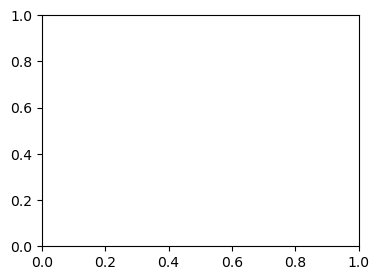

In [135]:
team_id = 931
team2_id = 1005 

home_name, df_home = get_corner_stats(team_id,True)
away_name, df_away = get_corner_stats(team2_id,False)

print(home_name, "Jogando em casa")
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.hist(df_home.total_first_half_corners.tolist(), int(df_home.total_match_corners.quantile(1)), rwidth=0.9)
plt.title("Escanteios total primeiro tempo")
plt.plot()
plt.subplot(1, 2, 2)
plt.hist(df_home.total_match_corners.tolist(), int(df_home.total_match_corners.quantile(1)), rwidth=0.9)
plt.title("Escanteios total partida")
plt.plot()
plt.tight_layout()
plt.show()

print(" PRIMEIRO TEMPO: ")
print('1H 85% das partidas - de', df_home.total_first_half_corners.quantile(0.85,interpolation="higher")+0.5, "escanteios")
print('1H 85% das partidas + de ', df_home.total_first_half_corners.quantile(0.15, interpolation="lower")-0.5, "escanteios")
print('1H partidas com menos de 6.5 ', round((df_home.total_first_half_corners < 7).mean()*100), "%", 'Fairline:',round(1/(df_home.total_first_half_corners < 7).mean(),2))
print('1H partidas com menos de 5.5 ', round((df_home.total_first_half_corners < 6).mean()*100), "%", 'Fairline:',round(1/(df_home.total_first_half_corners < 6).mean(),2))
print('1H partidas com menos de 4.5 ', round((df_home.total_first_half_corners < 5).mean()*100), "%", 'Fairline:',round(1/(df_home.total_first_half_corners < 5).mean(),2))
print('1H partidas com mais de 1.5 ', round((df_home.total_first_half_corners > 1).mean()*100), "%", 'Fairline:',round(1/(df_home.total_first_half_corners > 1).mean(),2))
print('1H partidas com mais de 2.5 ', round((df_home.total_first_half_corners > 2).mean()*100), "%", 'Fairline:',round(1/(df_home.total_first_half_corners > 2).mean(),2))
print('1H partidas com mais de 3.5 ', round((df_home.total_first_half_corners > 3).mean()*100), "%", 'Fairline:',round(1/(df_home.total_first_half_corners > 3).mean(),2))
print("JOGO COMPLETO: ")
print('FT 85% das partidas - de ', df_home.total_match_corners.quantile(0.85,interpolation="higher")+0.5, "escanteios")
print('FT 85% das partidas + de ', df_home.total_match_corners.quantile(0.15,interpolation="lower")-0.5, "escanteios")
print('FT partidas com menos de 10.5 ', round((df_home.total_match_corners < 11).mean()*100), "%", 'Fairline:',round(1/(df_home.total_match_corners < 11).mean(),2))
print('FT partidas com menos de 9.5 ', round((df_home.total_match_corners < 10).mean()*100), "%", 'Fairline:',round(1/(df_home.total_match_corners < 10).mean(),2))
print('FT partidas com menos de 8.5 ', round((df_home.total_match_corners < 9).mean()*100), "%", 'Fairline:',round(1/(df_home.total_match_corners < 9).mean(),2))
print('FT partidas com mais de 6.5 ', round((df_home.total_match_corners > 6).mean()*100), "%", 'Fairline:',round(1/(df_home.total_match_corners > 6).mean(),2))
print('FT partidas com mais de 7.5 ', round((df_home.total_match_corners > 7).mean()*100), "%", 'Fairline:',round(1/(df_home.total_match_corners > 7).mean(),2))
print('FT partidas com mais de 8.5 ', round((df_home.total_match_corners > 8).mean()*100), "%", 'Fairline:',round(1/(df_home.total_match_corners > 8).mean(),2))
print('Partidas com saldo de escanteios positivo: ', round((df_home.corners_balance > 0).mean()*100), "%")
print('Partidas com saldo de escanteios negativo: ', round((df_home.corners_balance < 0).mean()*100), "%")
print('Partidas escanteios empatados: ', round((df_home.corners_balance == 0).mean()*100), "%")
print('Média escanteios por partida: ', round((df_home.total_match_corners).mean()))
print('desvio padrão: ', round((df_home.total_match_corners).std()))
display(df_home)


print(away_name,"Jogando fora de casa")
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.hist(df_away.total_first_half_corners.tolist(), int(df_away.total_match_corners.quantile(1)), rwidth=0.9)
plt.title("Escanteios total primeiro tempo")
plt.plot()
plt.subplot(1, 2, 2)
plt.hist(df_away.total_match_corners.tolist(), int(df_away.total_match_corners.quantile(1)), rwidth=0.9)
plt.title("Escanteios total partida")
plt.plot()
plt.tight_layout()
plt.show()
print(" PRIMEIRO TEMPO: ")
print('1H 85% das partidas - de', df_away.total_first_half_corners.quantile(0.85,interpolation="higher")+.5, "escanteios")
print('1H 85% das partidas + de ', df_away.total_first_half_corners.quantile(0.15, interpolation="lower")-.5, "escanteios")
print('1H partidas com menos de 6.5 ', round((df_away.total_first_half_corners < 7).mean()*100), "%", 'Fairline:',round(1/(df_away.total_first_half_corners < 7).mean(),2))
print('1H partidas com menos de 5.5 ', round((df_away.total_first_half_corners < 6).mean()*100), "%", 'Fairline:',round(1/(df_away.total_first_half_corners < 6).mean(),2))
print('1H partidas com menos de 4.5 ', round((df_away.total_first_half_corners < 5).mean()*100), "%", 'Fairline:',round(1/(df_away.total_first_half_corners < 5).mean(),2))
print('1H partidas com mais de 1.5 ', round((df_away.total_first_half_corners > 1).mean()*100), "%", 'Fairline:',round(1/(df_away.total_first_half_corners > 1).mean(),2))
print('1H partidas com mais de 2.5 ', round((df_away.total_first_half_corners > 2).mean()*100), "%", 'Fairline:',round(1/(df_away.total_first_half_corners > 2).mean(),2))
print('1H partidas com mais de 3.5 ', round((df_away.total_first_half_corners > 3).mean()*100), "%", 'Fairline:',round(1/(df_away.total_first_half_corners > 3).mean(),2))
print("JOGO COMPLETO: ")
print('FT 85% das partidas - de ', df_away.total_match_corners.quantile(0.85,interpolation="higher")+.5, "escanteios")
print('FT 85% das partidas + de ', df_away.total_match_corners.quantile(0.15,interpolation="lower")-.5, "escanteios")
print('FT partidas com menos de 10.5 ', round((df_away.total_match_corners < 11).mean()*100), "%", 'Fairline:',round(1/(df_away.total_match_corners < 11).mean(),2))
print('FT partidas com menos de 9.5 ', round((df_away.total_match_corners < 10).mean()*100), "%", 'Fairline:',round(1/(df_away.total_match_corners < 10).mean(),2))
print('FT partidas com menos de 8.5 ', round((df_away.total_match_corners < 9).mean()*100), "%", 'Fairline:',round(1/(df_away.total_match_corners < 9).mean(),2))
print('FT partidas com mais de 6.5 ', round((df_away.total_match_corners > 6).mean()*100), "%", 'Fairline:',round(1/(df_away.total_match_corners > 6).mean(),2))
print('FT partidas com mais de 7.5 ', round((df_away.total_match_corners > 7).mean()*100), "%", 'Fairline:',round(1/(df_away.total_match_corners > 7).mean(),2))
print('FT partidas com mais de 8.5 ', round((df_away.total_match_corners > 8).mean()*100), "%", 'Fairline:',round(1/(df_away.total_match_corners > 8).mean(),2))
print('Partidas com saldo de escanteios positivo: ', round((df_away.corners_balance > 0).mean()*100), "%")
print('Partidas com saldo de escanteios negativo: ', round((df_away.corners_balance < 0).mean()*100), "%")
print('Partidas escanteios empatados: ', round((df_away.corners_balance == 0).mean()*100), "%")
print('Média escanteios por partida: ', round((df_away.total_match_corners).mean()))
print('desvio padrão: ', round((df_away.total_match_corners).std()))
display(df_away)
